# Introduction
This notebook preprocesses the data sets eventually used for modeling for our PLODI platform. This combines PPP loan data, USPS address verification, Census based business characteristics (CBSA), and labeled case information. As part of this review, inclusion and exclusion of specific features as well as treatment of empty values are considered


# Notebook Setup

In [1]:
import os
import re
import gc
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
%matplotlib inline

## Notebook Functions

In [2]:
# Extended descriptive statistics and information for Pandas dataframe

def display_stats(df):
    df_eda = df.describe(include='all').T
    df_eda['isnull'] = df.isnull().sum(axis = 0)
    df_eda['isna'] = df.isna().sum(axis = 0)
    df_eda['nunique'] = df.nunique(axis = 0)
    df_eda['dtypes'] = df.dtypes

    cols = ['count', 'nunique', 'dtypes', 'isnull', 'isna', 'top', 'freq', 'mean',
        'std', 'min', '25%', '50%', '75%', 'max']

    display(df_eda[cols])



```
# This is formatted as code
```

## Connecting Google Drive for data storage

In [3]:
# Mount Google Drive and confirm access permissions to permitaccess for data located on Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify project directory personal filepaths under Google Drive
user_proj_path = ''

proj_dir = '/content/drive/MyDrive/' + user_proj_path + 'plodi/'
proj_dir_data_raw = proj_dir + 'data/raw/'
proj_dir_data_proc = proj_dir + 'data/processed/'

dirs = [proj_dir, proj_dir_data_raw, proj_dir_data_proc]

for dir in dirs:
    print('-----------------------------------------------------------------------')
    print('Directory contents for ', dir)
    %ls {dir}

Mounted at /content/drive
-----------------------------------------------------------------------
Directory contents for  /content/drive/MyDrive/plodi/
data/  notebooks/
-----------------------------------------------------------------------
Directory contents for  /content/drive/MyDrive/plodi/data/raw/
2-6%20digit_2017_Codes.xlsx      public_up_to_150k_11_230630.csv  public_up_to_150k_6_230630.csv
2-6%20digit_2022_Codes.xlsx      public_up_to_150k_12_230630.csv  public_up_to_150k_7_230630.csv
6-digit_2017_Codes.xlsx          public_up_to_150k_1_230630.csv   public_up_to_150k_8_230630.csv
6-digit_2022_Codes.xlsx          public_up_to_150k_2_230630.csv   public_up_to_150k_9_230630.csv
ppp-data-dictionary.xlsx         public_up_to_150k_3_230630.csv   sba_ppp_combined.csv
public_150k_plus_230630.csv      public_up_to_150k_4_230630.csv   sba_ppp_merged.csv
public_up_to_150k_10_230630.csv  public_up_to_150k_5_230630.csv   US_Census_data.xlsx
-------------------------------------------------

In [4]:
# drive.mount("/content/drive", force_remount=True) # Run if the Google drive needs to be remounted

# Run after completing Notebook run to gracefully disconnect Gdrive
# drive.flush_and_unmount()

##System Specifications Information

In [5]:
# Check instance specs
!df -h
!cat /proc/cpuinfo
!cat /proc/meminfo

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Filesystem      Size  Used Avail Use% Mounted on
overlay         226G   27G  199G  12% /
tmpfs            64M     0   64M   0% /dev
shm              25G     0   25G   0% /dev/shm
/dev/root       2.0G  1.1G  849M  57% /usr/sbin/docker-init
tmpfs            26G  104K   26G   1% /var/colab
/dev/sda1       233G   28G  205G  12% /etc/hosts
tmpfs            26G     0   26G   0% /proc/acpi
tmpfs            26G     0   26G   0% /proc/scsi
tmpfs            26G     0   26G   0% /sys/firmware
drive           104G   68G   37G  65% /content/drive
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdp

In [6]:
#pd.set_option('display.max_columns', None)
#df_ppp_data.head(10)

# Downloading primary data sets

In [ ]:
sba_ppp_dict_url = 'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/aab8e9f9-36d1-42e1-b3ba-e59c79f1d7f0/download/ppp-data-dictionary.xlsx'

# Dynamic time-limited URLs for loans requiring SBA.gov queries for project specified date ranges
sba_ppp_url_list = [
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/4b3c3e7a-1286-4883-b857-d37058f9693c/download/public_150k_plus_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/c95195f6-0af6-4b84-8c65-e7cd6b940cc2/download/public_up_to_150k_1_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/eaa51a51-ef19-4c22-affe-61ede7253c6f/download/public_up_to_150k_2_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/eaa51a51-ef19-4c22-affe-61ede7253c6f/download/public_up_to_150k_3_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/b4ec101e-ad78-4a25-a058-ab03b049766b/download/public_up_to_150k_4_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/ea284b67-d0b7-4e65-bc48-663e9bb6dac1/download/public_up_to_150k_5_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/ef56afe8-08f8-4bfa-8a58-29690f5baae0/download/public_up_to_150k_6_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/81f1e2be-28a2-4854-bfe1-1e0d408f9fd0/download/public_up_to_150k_7_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/6ada73a2-8176-4e71-8689-30490d9f8a2f/download/public_up_to_150k_8_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/985f0c28-e799-4940-94a9-96a7c5c604a6/download/public_up_to_150k_9_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/3487edaa-92b3-47f4-b147-06fd6d79f786/download/public_up_to_150k_10_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/3487edaa-92b3-47f4-b147-06fd6d79f786/download/public_up_to_150k_11_230630.csv',
    'https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/3487edaa-92b3-47f4-b147-06fd6d79f786/download/public_up_to_150k_12_230630.csv',]


# Setting NAICS data URLs

naics_2017_2to6_digit_url = 'https://www.census.gov/naics/2017NAICS/2-6%20digit_2017_Codes.xlsx'
naics_2017_6_digit_url = 'https://www.census.gov/naics/2017NAICS/6-digit_2017_Codes.xlsx'
naics_2022_2to6_digit_url = 'https://www.census.gov/naics/2022NAICS/2-6%20digit_2022_Codes.xlsx'
naics_2022_6_digit_url = 'https://www.census.gov/naics/2022NAICS/6-digit_2022_Codes.xlsx'

%cd $proj_dir_data_raw # Set working directory for source data download

# Run first time to download SBA PPP data to Google Drive

!curl -O $sba_ppp_dict_url
for url in sba_ppp_url_list:
  !curl -O {url}

# Run first time to download NAICS codes to Google Drive

!curl -O {naics_2017_2to6_digit_url}
!curl -O {naics_2017_6_digit_url}
!curl -O {naics_2022_2to6_digit_url}
!curl -O {naics_2022_6_digit_url}

[Errno 2] No such file or directory: '/content/drive/MyDrive/plodi/data/raw/ # Set working directory for source data download'
/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11834  100 11834    0     0  45299      0 --:--:-- --:--:-- --:--:-- 45340
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6895  100  6895    0     0  24992      0 --:--:-- --:--:-- --:--:-- 24981
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6904  100  6904    0     0  25085      0 --:--:-- --:--:-- --:--:-- 25105
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  S

In [ ]:
!ls

2-6%20digit_2017_Codes.xlsx  public_up_to_150k_10_230630.csv  public_up_to_150k_4_230630.csv
2-6%20digit_2022_Codes.xlsx  public_up_to_150k_11_230630.csv  public_up_to_150k_5_230630.csv
6-digit_2017_Codes.xlsx      public_up_to_150k_12_230630.csv  public_up_to_150k_6_230630.csv
6-digit_2022_Codes.xlsx      public_up_to_150k_1_230630.csv   public_up_to_150k_7_230630.csv
ppp-data-dictionary.xlsx     public_up_to_150k_2_230630.csv   public_up_to_150k_8_230630.csv
public_150k_plus_230630.csv  public_up_to_150k_3_230630.csv   public_up_to_150k_9_230630.csv


In [7]:
# Load individual SBA PPP files
ppp_files_li = [filename for filename in os.listdir(proj_dir_data_raw) if filename.startswith('public_')]
df_ppp_data = pd.concat([pd.read_csv(proj_dir_data_raw+filename, header=0) for filename in ppp_files_li], ignore_index=True)

<ipython-input-7-4c92049d9417>:3: DtypeWarning: Columns (16,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ppp_data = pd.concat([pd.read_csv(proj_dir_data_raw+filename, header=0) for filename in ppp_files_li], ignore_index=True)


In [ ]:
# Load SBA PPP data dictionary
filename = 'ppp-data-dictionary.xlsx'
df_ppp_dict = pd.read_excel(proj_dir_data_raw+filename, header=0)

In [ ]:
!ls

2-6%20digit_2017_Codes.xlsx  public_up_to_150k_10_230630.csv  public_up_to_150k_5_230630.csv
2-6%20digit_2022_Codes.xlsx  public_up_to_150k_11_230630.csv  public_up_to_150k_6_230630.csv
6-digit_2017_Codes.xlsx      public_up_to_150k_12_230630.csv  public_up_to_150k_7_230630.csv
6-digit_2022_Codes.xlsx      public_up_to_150k_1_230630.csv   public_up_to_150k_8_230630.csv
drive			     public_up_to_150k_2_230630.csv   public_up_to_150k_9_230630.csv
ppp-data-dictionary.xlsx     public_up_to_150k_3_230630.csv   sample_data
public_150k_plus_230630.csv  public_up_to_150k_4_230630.csv


# Preliminary Review and Staging of PPP data set

In [ ]:
print(df_ppp_dict.shape, '\n')
display(df_ppp_dict)

(53, 2) 



,Field Name,Field Description
0,LoanNumber,Loan Number (unique identifier)
1,DateApproved,Loan Funded Date
2,SBAOfficeCode,SBA Origination Office Code
3,ProcessingMethod,Loan Delivery Method (PPP for first draw; PPS ...
4,BorrowerName,Borrower Name
5,BorrowerAddress,Borrower Street Address
6,BorrowerCity,Borrower City
7,BorrowerState,Borrower State
8,BorrowerZip,Borrower Zip Code
9,LoanStatusDate,Loan Status Date\n- Loan Status Date is blank...


In [ ]:
df_ppp_data.head(4).T

,0,1,2,3
LoanNumber,9595657403,9608808102,9611377305,9620717204
DateApproved,05/20/2020,07/28/2020,05/02/2020,04/28/2020
SBAOfficeCode,1086.0,1086.0,1086.0,1086.0
ProcessingMethod,PPP,PPP,PPP,PPP
BorrowerName,ALIVE & WELL HEALING ARTS,ISHIP EXPRESS LLC,HAIR THERE AND EVERYWHERE LLC,CARRIE DITULLIO REAL ESTATE
BorrowerAddress,1675 SW Marlow Ave,2900 SE CORNELIUS PASS RD STE 101,6220 Lake labish rd ne,1948 Rimrock Rd
BorrowerCity,Portland,HILLSBORO,Salem,BEND
BorrowerState,OR,OR,OR,OR
BorrowerZip,97225-5102,97123-9600,97305-3553,97703
LoanStatusDate,06/08/2021,03/17/2021,03/05/2021,12/17/2020


In [ ]:
df_ppp_eda = df_ppp_data.describe(include='all').T
df_ppp_eda['isnull'] = df_ppp_data.isnull().sum(axis = 0)
df_ppp_eda['isna'] = df_ppp_data.isna().sum(axis = 0)
df_ppp_eda['nunique'] = df_ppp_data.nunique(axis = 0)
df_ppp_eda['dtypes'] = df_ppp_data.dtypes

cols = ['count', 'nunique', 'dtypes', 'isnull', 'isna', 'top', 'freq', 'mean',
    'std', 'min', '25%', '50%', '75%', 'max']

df_ppp_eda[cols].style

,count,nunique,dtypes,isnull,isna,top,freq,mean,std,min,25%,50%,75%,max
LoanNumber,11765552.000000,9065552,int64,0,0,nan,nan,5465175977.965923,2569609225.341067,1000007108.000000,3266248810.000000,5449328855.500000,7649957852.000000,9999008900.000000
DateApproved,11765552,246,object,0,0,05/01/2020,796328,nan,nan,nan,nan,nan,nan,nan
SBAOfficeCode,11765524.000000,76,float64,28,28,nan,nan,510.765292,221.917236,101.000000,373.000000,470.000000,593.000000,9030.000000
ProcessingMethod,11765552,2,object,0,0,PPP,8813874,nan,nan,nan,nan,nan,nan,nan
BorrowerName,11765501,7054608,object,51,51,FIRST UNITED METHODIST CHURCH,661,nan,nan,nan,nan,nan,nan,nan
BorrowerAddress,11765352,7401361,object,200,200,PO BOX,706,nan,nan,nan,nan,nan,nan,nan
BorrowerCity,11765367,66601,object,185,185,Miami,158470,nan,nan,nan,nan,nan,nan,nan
BorrowerState,11765387,58,object,165,165,FL,1787943,nan,nan,nan,nan,nan,nan,nan
BorrowerZip,11765375,4025231,object,177,177,00926,8553,nan,nan,nan,nan,nan,nan,nan
LoanStatusDate,11328430,1005,object,437122,437122,03/22/2022,277376,nan,nan,nan,nan,nan,nan,nan


In [ ]:
col = 'LoanNumber'
df_ppp_data[df_ppp_data.duplicated(keep=False)].sort_values(by=[col]).T

,9853238,1753238,6276256,876256,3576256,81417,5481417,2781417,3065211,365211,...,971203,689644,3389644,6089644,5431110,31110,2731110,5794046,3094046,394046
LoanNumber,1000007707,1000007707,1000017307,1000017307,1000017307,1000028502,1000028502,1000028502,1000038701,1000038701,...,9998997100,9998998510,9998998510,9998998510,9999008203,9999008203,9999008203,9999008606,9999008606,9999008606
DateApproved,05/01/2020,05/01/2020,04/28/2020,04/28/2020,04/28/2020,02/18/2021,02/18/2021,02/18/2021,03/26/2021,03/26/2021,...,04/15/2020,03/12/2021,03/12/2021,03/12/2021,01/16/2021,01/16/2021,01/16/2021,03/26/2021,03/26/2021,03/26/2021
SBAOfficeCode,455.0,455.0,610.0,610.0,610.0,358.0,358.0,358.0,252.0,252.0,...,341.0,474.0,474.0,474.0,303.0,303.0,303.0,252.0,252.0,252.0
ProcessingMethod,PPP,PPP,PPP,PPP,PPP,PPS,PPS,PPS,PPS,PPS,...,PPP,PPP,PPP,PPP,PPS,PPS,PPS,PPP,PPP,PPP
BorrowerName,ANTIBES INCORPORATED,ANTIBES INCORPORATED,"RED GAP COMMUNICATIONS, INC","RED GAP COMMUNICATIONS, INC","RED GAP COMMUNICATIONS, INC",DAN GOVORA ELECTRICAL CONTRACTORS INC.,DAN GOVORA ELECTRICAL CONTRACTORS INC.,DAN GOVORA ELECTRICAL CONTRACTORS INC.,LEONOR INVESTMENT CORPORATION,LEONOR INVESTMENT CORPORATION,...,"PLAZA MEDICAL ASSOCIATES, LTD",PEYTON BAXTER LLC,PEYTON BAXTER LLC,PEYTON BAXTER LLC,"RETTEW'S CATERING, LLC","RETTEW'S CATERING, LLC","RETTEW'S CATERING, LLC",ELSA FRONTERA,ELSA FRONTERA,ELSA FRONTERA
BorrowerAddress,1781 SW 23RD TER,1781 SW 23RD TER,504 MAIN ST,504 MAIN ST,504 MAIN ST,700 Hidden Trl,700 Hidden Trl,700 Hidden Trl,HERMANOS DAVILA CALLE 3A #142,HERMANOS DAVILA CALLE 3A #142,...,"1600 N. Washington Street, 2nd Floor 2nd floor",109 Center Park Ln,109 Center Park Ln,109 Center Park Ln,309 S Main St,309 S Main St,309 S Main St,702 Calle Martin Guiluz Urb Fair View,702 Calle Martin Guiluz Urb Fair View,702 Calle Martin Guiluz Urb Fair View
BorrowerCity,MIAMI,MIAMI,FORT WORTH,FORT WORTH,FORT WORTH,Greensburg,Greensburg,Greensburg,BAYAMON,BAYAMON,...,Wilmington,Oak Ridge,Oak Ridge,Oak Ridge,Manheim,Manheim,Manheim,San Juan,San Juan,San Juan
BorrowerState,FL,FL,TX,TX,TX,PA,PA,PA,PR,PR,...,DE,TN,TN,TN,PA,PA,PA,PR,PR,PR
BorrowerZip,33145,33145,76102-3925,76102-3925,76102-3925,15601-8316,15601-8316,15601-8316,00959,00959,...,19802,37830-9026,37830-9026,37830-9026,17545-2212,17545-2212,17545-2212,00926-7754,00926-7754,00926-7754
LoanStatusDate,04/22/2021,04/22/2021,02/10/2021,02/10/2021,02/10/2021,09/24/2021,09/24/2021,09/24/2021,03/18/2022,03/18/2022,...,07/08/2021,08/14/2021,08/14/2021,08/14/2021,10/08/2021,10/08/2021,10/08/2021,08/20/2021,08/20/2021,08/20/2021


# Initial Data Cleaning / Preprocessing

In [8]:
# Remove duplicate loans where all columns have equivalent values. This is an
# artifact for overlap of data when querying the US government website as only
# a fixed number of sub-results based on query range are available in
# individual files and need to be combined.

df_ppp_clean = df_ppp_data.copy(deep=True).drop_duplicates()

print('There are', df_ppp_clean['LoanNumber'].nunique(), 'unique loans and',
      df_ppp_clean['LoanNumber'].shape[0], 'total loans after deduplicating',
      'across all columns.')

There are 9065552 unique loans and 9065552 total loans after deduplicating across all columns.


In [9]:
# Convert date fields to DateTime format

df_ppp_clean['DateApproved'] = pd.to_datetime(df_ppp_clean['DateApproved'])
df_ppp_clean['LoanStatusDate'] = pd.to_datetime(df_ppp_clean['LoanStatusDate'])
df_ppp_clean['ForgivenessDate'] = pd.to_datetime(df_ppp_clean['ForgivenessDate'])

In [10]:
# Drop loans that have 'Exemption 6', which is a designation by government
# agencies where information is removed from FOIA requests and here
# where salient loan information is not available. Similarly, because
# of the large size of the primary data set and relatively small number
# of positive labels for prosecuted cases, because Borrower Name is a key
# field and primary identifier for any external validation, these rows have
# been dropped.

df_ppp_clean.drop(df_ppp_clean.loc[df_ppp_clean['BorrowerName']=='Exemption 6'].index, inplace=True)
df_ppp_clean.drop(df_ppp_clean.loc[df_ppp_clean['BorrowerName'].isnull()==True].index, inplace=True)

In [ ]:
display_stats(df_ppp_clean)

<ipython-input-51-fa09dfe27c86>:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_eda = df.describe(include='all').T
<ipython-input-51-fa09dfe27c86>:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_eda = df.describe(include='all').T
<ipython-input-51-fa09dfe27c86>:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_eda = df.describe(include='all').T


,count,nunique,dtypes,isnull,isna,top,freq,mean,std,min,25%,50%,75%,max
LoanNumber,9065484.0,9065484,int64,0,0,NaN,NaN,5455130888.359578,2570457868.562289,1000007108.0,3249957252.0,5442098556.0,7638361009.0,9999008900.0
DateApproved,9065484,246,datetime64[ns],0,0,2020-05-01 00:00:00,623246,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SBAOfficeCode,9065484.0,76,float64,0,0,NaN,NaN,529.601626,232.350786,101.0,405.0,491.0,679.0,9030.0
ProcessingMethod,9065484,2,object,0,0,PPP,6783512,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BorrowerName,9065484,7054607,object,0,0,FIRST UNITED METHODIST CHURCH,501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BorrowerAddress,9065324,7401332,object,160,160,PO BOX,498,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BorrowerCity,9065334,66601,object,150,150,Chicago,154049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BorrowerState,9065347,58,object,137,137,FL,983253,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BorrowerZip,9065338,4025216,object,146,146,10001,3261,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoanStatusDate,8730746,1005,datetime64[ns],334738,334738,2022-03-22 00:00:00,207525,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_ppp_clean.head(5)

,LoanNumber,DateApproved,SBAOfficeCode,ProcessingMethod,BorrowerName,BorrowerAddress,BorrowerCity,BorrowerState,BorrowerZip,LoanStatusDate,...,BusinessType,OriginatingLenderLocationID,OriginatingLender,OriginatingLenderCity,OriginatingLenderState,Gender,Veteran,NonProfit,ForgivenessAmount,ForgivenessDate
0,2593527208,2020-04-16,1094.0,PPP,"LORI L. HOLDER, LCSW",504 MAIN ST Suite 472,LEWISTON,ID,83501-1806,2021-02-24,...,Sole Proprietorship,59698.0,Umpqua Bank,ROSEBURG,OR,Unanswered,Unanswered,NaN,503.92,2021-02-12
1,2741007306,2020-04-29,1087.0,PPP,THUNDER HILL FITNESS CENTER LLC,283 S. Middlefork Rd,GARDEN VALLEY,ID,83622,2021-06-22,...,Limited Liability Partnership,106925.0,Mountain America FCU,SANDY,UT,Unanswered,Unanswered,NaN,505.25,2021-05-25
2,3342508906,2021-04-28,1087.0,PPP,KATRINA RAMIREZ,2877 N Bliss Dr,Idaho Falls,ID,83401-5873,2021-11-11,...,Self-Employed Individuals,317954.0,"Newtek Small Business Finance, Inc.",LAKE SUCCESS,NY,Unanswered,Unanswered,NaN,502.43,2021-10-27
3,3379798208,2020-08-04,1087.0,PPP,JAMES PARIS SCHOOL OF MUSIC,3048 W SAN REMO ST,MERIDIAN,ID,83646-3214,2021-02-03,...,Sole Proprietorship,96211.0,Idaho Central CU,CHUBBUCK,ID,Male Owned,Unanswered,NaN,502.16,2021-01-12
4,3753429003,2021-05-20,1087.0,PPP,ANGEL RICE,4088 S Riva Ridge Way,Boise,ID,83709-4448,2022-03-22,...,Independent Contractors,188361.0,"Prestamos CDFI, LLC",Phoenix,AZ,Female Owned,Non-Veteran,NaN,503.40,2022-02-03


In [ ]:
# Export combined SBA PPP files after removal of specified rows
filename = 'sba_ppp_combined.csv'
df_ppp_clean.to_csv(proj_dir_data_raw+filename, index=False)

# Addition of secondary data labels and addressing empty or NA fields to create a clean dataset ready for modeling

In [11]:
df_ppp_merge = df_ppp_clean.copy(deep=True)

## Addition of CBSA industry features

In [12]:
# Truncate NAICS code to parent industry level for comparison to CBSA data
df_ppp_merge['NAICSCode_2digits'] = df_ppp_merge['NAICSCode'].astype(str).str[:2]

# Create the implied employee pay per year for each PPP loan as reported by the
# PPP loan application and clip pay for modeling analysis.
df_ppp_merge['avg_employee_pay'] = df_ppp_merge['InitialApprovalAmount']/df_ppp_merge['JobsReported'] / 1000 / 2.5 * 12
df_ppp_merge['avg_employee_pay'] = df_ppp_merge['avg_employee_pay'].clip(0, 130)

In [13]:
# Read in the CBSA feature for average annual payroll by state/NAICS codes
filename = 'US_Census_data.xlsx'
cbsa_data = pd.read_excel(proj_dir_data_raw+filename, header=0)
census_grouped = cbsa_data.groupby(['State_AB','NAICS Code'])['Average annual payroll ($1,000)'].mean().reset_index()
census_grouped['NAICS Code'] = census_grouped['NAICS Code'].astype(str)

In [ ]:
cbsa_data.head(5)

,State FIPS,State,118th Congressional District,2017 NAICS Code,NAICS Description,Number of Establishments,Employment,Employment Noise Flag,"1st Quarter Payroll ($1,000)",1st Quarter Payroll Noise Flag,"Annual Payroll ($1,000)",Annual Payroll Noise Flag,Year,"Average annual payroll ($1,000)",State_AB,NAICS Code
0,1,Alabama,1,11----,"Agriculture, forestry, fishing and hunting",132,937,G,10051,G,45283,G,2021,48.327641,AL,11
1,1,Alabama,1,21----,"Mining, quarrying, and oil and gas extraction",26,295,H,6001,G,23476,G,2021,79.579661,AL,21
2,1,Alabama,1,22----,Utilities,46,1383,G,45594,H,148906,H,2021,107.668836,AL,22
3,1,Alabama,1,23----,Construction,1533,17390,G,214351,G,965591,G,2021,55.525647,AL,23
4,1,Alabama,1,31----,Manufacturing,572,25471,G,438931,G,1858642,G,2021,72.970908,AL,31


In [ ]:
census_grouped.isnull().sum(axis=0)

State_AB                           0
NAICS Code                         0
Average annual payroll ($1,000)    0
dtype: int64

In [14]:
# Add CBSA features to merged data frame
df_ppp_merge = df_ppp_merge.merge(census_grouped, left_on = ['BorrowerState','NAICSCode_2digits'], right_on = ['State_AB','NAICS Code'], how = 'left')
df_ppp_merge.head(5)

,LoanNumber,DateApproved,SBAOfficeCode,ProcessingMethod,BorrowerName,BorrowerAddress,BorrowerCity,BorrowerState,BorrowerZip,LoanStatusDate,...,Gender,Veteran,NonProfit,ForgivenessAmount,ForgivenessDate,NAICSCode_2digits,avg_employee_pay,State_AB,NAICS Code,"Average annual payroll ($1,000)"
0,2593527208,2020-04-16,1094.0,PPP,"LORI L. HOLDER, LCSW",504 MAIN ST Suite 472,LEWISTON,ID,83501-1806,2021-02-24,...,Unanswered,Unanswered,NaN,503.92,2021-02-12,62,2.4,ID,62,48.484265
1,2741007306,2020-04-29,1087.0,PPP,THUNDER HILL FITNESS CENTER LLC,283 S. Middlefork Rd,GARDEN VALLEY,ID,83622,2021-06-22,...,Unanswered,Unanswered,NaN,505.25,2021-05-25,71,1.2,ID,71,20.598719
2,3342508906,2021-04-28,1087.0,PPP,KATRINA RAMIREZ,2877 N Bliss Dr,Idaho Falls,ID,83401-5873,2021-11-11,...,Unanswered,Unanswered,NaN,502.43,2021-10-27,42,2.4,ID,42,68.046392
3,3379798208,2020-08-04,1087.0,PPP,JAMES PARIS SCHOOL OF MUSIC,3048 W SAN REMO ST,MERIDIAN,ID,83646-3214,2021-02-03,...,Male Owned,Unanswered,NaN,502.16,2021-01-12,81,2.4,ID,81,31.484254
4,3753429003,2021-05-20,1087.0,PPP,ANGEL RICE,4088 S Riva Ridge Way,Boise,ID,83709-4448,2022-03-22,...,Female Owned,Non-Veteran,NaN,503.40,2022-02-03,49,2.4,NaN,NaN,NaN


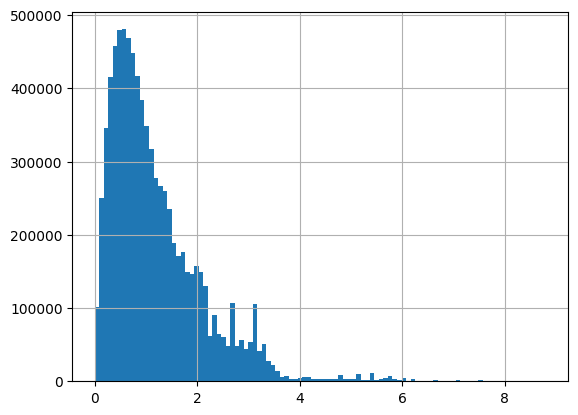

In [15]:
# Create average pay ratio to NAICS data and clip values for later model analysis
df_ppp_merge['pay_ratio'] = df_ppp_merge['avg_employee_pay']/df_ppp_merge['Average annual payroll ($1,000)']
df_ppp_merge.pay_ratio.hist(bins=100)
df_ppp_merge['pay_ratio'] = df_ppp_merge['pay_ratio'].clip(0, 10)
#df_ppp_merge.pay_ratio.hist(bins=100)
#df_ppp_merge.avg_employee_pay.hist(bins=100)
#df_ppp_merge.head()

##Addition of USPS address verification feature

In [16]:
# USPS address verification of addresses for PPP loans were conducted through a
# separate code file which can be referenced in the Git repo and output to the
# referenced file below.
filename = 'LoanNumber_USPS_GEOID.csv'
df_usps = pd.read_csv(proj_dir_data_proc+filename, header=0)

<ipython-input-16-34f34246841e>:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_usps = pd.read_csv(proj_dir_data_proc+filename, header=0)


In [17]:
print(df_usps.USPSAPI_Result.value_counts(dropna=False), '\n',
      df_usps.columns.tolist())

 USPSAPI_Result: True                                           8900287
NaN                                                             2020602
 USPSAPI_Result: More Information Needed to Validate Address     844663
Name: USPSAPI_Result, dtype: int64 
 ['Unnamed: 0', 'LoanNumber', 'USPSAPI_Result', 'GEOID20', 'GEOID']


In [18]:
# Set verified addresses to  1 and all else to 0

df_ppp_merge['Verified_Address'] = df_usps['USPSAPI_Result'].map({' USPSAPI_Result: True': 1, ' USPSAPI_Result: More Information Needed to Validate Address': 0}).fillna(0)
df_ppp_merge.Verified_Address.value_counts(dropna=False)

1.0    7619447
0.0    1446037
Name: Verified_Address, dtype: int64

## Addition of labelled prosecuted case feature

In [19]:
# Loan manually labelled prosecuted case file to add feature label for those
# loans that met OIG investigative rigor for prosecution as positive labels
# for training. These cases were reviewed at a document level and then manually
# matched back to the defendants and companies and linked back to loan number
filename = 'labelled_unique.csv'
df_case = pd.read_csv(proj_dir_data_proc+filename, header=0)

In [ ]:
df_case.head(2)

,Unnamed: 0,LoanNumber,BorrowerName,BorrowerNameProc,index,State,Lookup,Fraud,Status,lookupproc,lookup_li,case_index
0,0,1697388504,TIMOTHY WILLIAMS,timothy williams,52,Georgia,Timothy Williams;Bamigi Brand,0,unclear,timothy williams;bamigi brand,timothy williams,52
1,1,3657298201,TIMOTHY WILLIAMS,timothy williams,52,Georgia,Timothy Williams;Bamigi Brand,0,unclear,timothy williams;bamigi brand,timothy williams,52


In [ ]:
print(df_case.nunique(axis=0, columns))

Unnamed: 0          626
LoanNumber          626
BorrowerName        260
BorrowerNameProc    194
index                79
State                20
Lookup               79
Fraud                 2
Status                4
lookupproc           79
lookup_li           194
case_index           79
dtype: int64


In [20]:
df_ppp_merge['CaseLabel'] = df_ppp_merge['LoanNumber'].isin(df_case['LoanNumber'])

In [ ]:
df_ppp_merge.head(5)

,LoanNumber,DateApproved,SBAOfficeCode,ProcessingMethod,BorrowerName,BorrowerAddress,BorrowerCity,BorrowerState,BorrowerZip,LoanStatusDate,...,ForgivenessAmount,ForgivenessDate,NAICSCode_2digits,avg_employee_pay,State_AB,NAICS Code,"Average annual payroll ($1,000)",pay_ratio,Verified_Address,CaseLabel
0,2593527208,2020-04-16,1094.0,PPP,"LORI L. HOLDER, LCSW",504 MAIN ST Suite 472,LEWISTON,ID,83501-1806,2021-02-24,...,503.92,2021-02-12,62,2.4,ID,62,48.484265,0.049501,1.0,False
1,2741007306,2020-04-29,1087.0,PPP,THUNDER HILL FITNESS CENTER LLC,283 S. Middlefork Rd,GARDEN VALLEY,ID,83622,2021-06-22,...,505.25,2021-05-25,71,1.2,ID,71,20.598719,0.058256,1.0,False
2,3342508906,2021-04-28,1087.0,PPP,KATRINA RAMIREZ,2877 N Bliss Dr,Idaho Falls,ID,83401-5873,2021-11-11,...,502.43,2021-10-27,42,2.4,ID,42,68.046392,0.035270,1.0,False
3,3379798208,2020-08-04,1087.0,PPP,JAMES PARIS SCHOOL OF MUSIC,3048 W SAN REMO ST,MERIDIAN,ID,83646-3214,2021-02-03,...,502.16,2021-01-12,81,2.4,ID,81,31.484254,0.076229,1.0,False
4,3753429003,2021-05-20,1087.0,PPP,ANGEL RICE,4088 S Riva Ridge Way,Boise,ID,83709-4448,2022-03-22,...,503.40,2022-02-03,49,2.4,NaN,NaN,NaN,NaN,1.0,False


In [ ]:
# Export merged file with addition of labelled case data, CBSA average salary,
# and address verification features
filename = 'sba_ppp_merged.csv'
df_ppp_merge.to_csv(proj_dir_data_proc+filename, index=False)

# Further Data Validation and Cleansing through Reconciliation of NA values

In [21]:
df_model_data = df_ppp_merge.copy(deep=True)

In [22]:
cols = [
    'DateApproved',
    'BorrowerName',
    'BorrowerAddress',
    'BorrowerCity',
    'BorrowerState',
    'BorrowerZip',
    'LoanStatusDate',
    'SBAGuarantyPercentage',
    'UndisbursedAmount',
    'FranchiseName',
    'ServicingLenderLocationID',
    'ServicingLenderAddress',
    'ServicingLenderCity',
    'ServicingLenderState',
    'ServicingLenderZip',
    'ProjectCity',
    'ProjectCountyName',
    'ProjectState',
    'ProjectZip',
    'NAICSCode',
    'OriginatingLenderLocationID',
    'OriginatingLenderCity',
    'OriginatingLenderState',
    'ForgivenessDate',
    'State_AB',
    'NAICS Code']
df_model_data = df_model_data.drop(columns=cols)

In [23]:
display_stats(df_model_data)

,count,nunique,dtypes,isnull,isna,top,freq,mean,std,min,25%,50%,75%,max
LoanNumber,9065484.0,9065484,int64,0,0,NaN,NaN,5455130888.359578,2570457868.562289,1000007108.0,3249957252.0,5442098556.0,7638361009.0,9999008900.0
SBAOfficeCode,9065484.0,76,float64,0,0,NaN,NaN,529.601626,232.350786,101.0,405.0,491.0,679.0,9030.0
ProcessingMethod,9065484,2,object,0,0,PPP,6783512,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoanStatus,9065484,3,object,0,0,Paid in Full,8363426,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Term,9065484.0,136,int64,0,0,NaN,NaN,45.075137,17.6598,0.0,24.0,60.0,60.0,213.0
InitialApprovalAmount,9065484.0,1013945,float64,0,0,NaN,NaN,81784.120373,290375.188397,-199659.0,10200.0,20832.0,49470.0,10000000.0
CurrentApprovalAmount,9065484.0,1021705,float64,0,0,NaN,NaN,81380.69675,287494.68067,0.0,10200.0,20832.0,49300.0,10000000.0
ServicingLenderName,9065484,4594,object,0,0,"Harvest Small Business Finance, LLC",483820,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RuralUrbanIndicator,9065484,2,object,0,0,U,6975544,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HubzoneIndicator,9065484,2,object,0,0,N,6365538,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Evaluate whether jobs reported NA of 5 records is labeled case data otherwise
# drop records given the relative size of data set
df_model_data[df_model_data['JobsReported'].isnull()==True]['CaseLabel'].sum()

0

In [25]:
# Dropping represented loan rows (5) for which jobs and payroll data were not
# reported in the FOIA PPP data as these are not labelled cases and the majority
# unlabelled class is significantly larger
cols = [
    'JobsReported'
]
df_model_data.dropna(subset=cols, inplace=True)

In [26]:
# Fill NAs for categorical and/or numerical variables based on negative
# or unknown category for variable or net new unknown as indicated.

fillna_dict = {
    'LMIIndicator': 'N',
    'BusinessAgeDescription': 'Existing or more than 2 years old',
    'CD': 'NA-00',  # Create new unknown entry for unknown Congress District
    'UTILITIES_PROCEED': 0,
    'PAYROLL_PROCEED': 0,
    'MORTGAGE_INTEREST_PROCEED': 0,
    'RENT_PROCEED': 0,
    'REFINANCE_EIDL_PROCEED': 0,
    'HEALTH_CARE_PROCEED': 0,
    'DEBT_INTEREST_PROCEED': 0,
    'BusinessType': 'Not Listed',
    'NonProfit': 'N',
    'ForgivenessAmount': 0,
    }

df_model_data.fillna(value=fillna_dict, inplace=True)

In [27]:
display_stats(df_model_data)

,count,nunique,dtypes,isnull,isna,top,freq,mean,std,min,25%,50%,75%,max
LoanNumber,9065479.0,9065479,int64,0,0,NaN,NaN,5455131182.553323,2570458524.641552,1000007108.0,3249953004.5,5442098801.0,7638367058.0,9999008900.0
SBAOfficeCode,9065479.0,76,float64,0,0,NaN,NaN,529.60157,232.350683,101.0,405.0,491.0,679.0,9030.0
ProcessingMethod,9065479,2,object,0,0,PPP,6783507,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoanStatus,9065479,3,object,0,0,Paid in Full,8363422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Term,9065479.0,136,int64,0,0,NaN,NaN,45.075144,17.659798,0.0,24.0,60.0,60.0,213.0
InitialApprovalAmount,9065479.0,1013945,float64,0,0,NaN,NaN,81784.116338,290375.256787,-199659.0,10200.0,20832.0,49470.0,10000000.0
CurrentApprovalAmount,9065479.0,1021705,float64,0,0,NaN,NaN,81380.692493,287494.748142,0.0,10200.0,20832.0,49300.0,10000000.0
ServicingLenderName,9065479,4594,object,0,0,"Harvest Small Business Finance, LLC",483820,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RuralUrbanIndicator,9065479,2,object,0,0,U,6975540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HubzoneIndicator,9065479,2,object,0,0,N,6365533,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Pay ratio which is an imputed value based on the loan reported business
# payroll and employees compared to the CBSA payroll information based on
# location and NAICS data. Evaluating how many of the remaining PayRatio NA
# values are labeled cases
df_model_data[df_model_data['CaseLabel']==True]['pay_ratio'].isnull().sum()

# df=df_model_data[df_model_data['CaseLabel']==True]
# df[df['pay_ratio'].isna()==True]

63

In [29]:
# Identifying mean values for Pay Ratio for FillNA function on missing values

print('Average pay ratio for positive labeled loans: ',
      df_model_data[df_model_data['CaseLabel']==True]['pay_ratio'].mean(),
      '\nAverage pay ratio for unknown labeled loans: ',
      df_model_data[df_model_data['CaseLabel']==False]['pay_ratio'].mean(),
      '\nAverage pay ratio for all loans: ',
      df_model_data['pay_ratio'].mean())

pay_ratio_avg = df_model_data['pay_ratio'].mean()

Average pay ratio for positive labeled loans:  1.4281328750834246 
Average pay ratio for unknown labeled loans:  1.196019239624647 
Average pay ratio for all loans:  1.196035065390153


In [30]:
#Fill NANs for pay ratio with the mean across all loans
cols = ['pay_ratio']
df_model_data[cols] = df_model_data[cols].fillna(value=pay_ratio_avg)

In [ ]:
df_model_data['pay_100k'] = np.where(((df_model_data['avg_employee_pay'] % 100) <= 1) |
                                  ((df_model_data['avg_employee_pay'] % 100) >= 99), 1, 0)

df_model_data['pay_100k'].value_counts(normalize=True, dropna=False)

0    0.858648
1    0.141352
Name: pay_100k, dtype: float64

In [31]:
# Add an additional binary feature that evalutes whether each business applying
# for a loan is above an identified threshold for pay ratio compared to CBSA
# data
df_model_data['pay_ratio_binary'] = (df_model_data['pay_ratio'] >= 3).astype(int)
df_model_data['pay_ratio_binary'].value_counts(normalize=True, dropna=False)

0    0.9499
1    0.0501
Name: pay_ratio_binary, dtype: float64

In [ ]:
# Export merged file with addition of labelled case data, CBSA average salary,
# and address verification features
filename = 'modelling_data_preproc.csv'
df_model_data.to_csv(proj_dir_data_proc+filename, index=False)

# Convert non-numerical values to categorical variables and store in dictionary

In [32]:
for label in df_model_data.columns.tolist():
    print(label, ': ', df_model_data[label].dtype)

LoanNumber :  int64
SBAOfficeCode :  float64
ProcessingMethod :  object
LoanStatus :  object
Term :  int64
InitialApprovalAmount :  float64
CurrentApprovalAmount :  float64
ServicingLenderName :  object
RuralUrbanIndicator :  object
HubzoneIndicator :  object
LMIIndicator :  object
BusinessAgeDescription :  object
CD :  object
JobsReported :  float64
Race :  object
Ethnicity :  object
UTILITIES_PROCEED :  float64
PAYROLL_PROCEED :  float64
MORTGAGE_INTEREST_PROCEED :  float64
RENT_PROCEED :  float64
REFINANCE_EIDL_PROCEED :  float64
HEALTH_CARE_PROCEED :  float64
DEBT_INTEREST_PROCEED :  float64
BusinessType :  object
OriginatingLender :  object
Gender :  object
Veteran :  object
NonProfit :  object
ForgivenessAmount :  float64
NAICSCode_2digits :  object
avg_employee_pay :  float64
Average annual payroll ($1,000) :  float64
pay_ratio :  float64
Verified_Address :  float64
CaseLabel :  bool
pay_ratio_binary :  int64


In [33]:
# Converting columns to categorical data type for modelling
df_cat_dict = pd.DataFrame()

cols = [
    'SBAOfficeCode',
    'ProcessingMethod',
    'LoanStatus',
    'Term',
    'ServicingLenderName',
    'RuralUrbanIndicator',
    'HubzoneIndicator',
    'LMIIndicator',
    'BusinessAgeDescription',
    'CD',
    'Race',
    'Ethnicity',
    'BusinessType',
    'OriginatingLender',
    'Gender',
    'Veteran',
    'NonProfit',
    'NAICSCode_2digits',
    'Verified_Address',
    'CaseLabel']

for col in cols:
    new_col = col + '_cat'

    df_model_data[new_col] = pd.Categorical(df_model_data[col])
    df_cat_dict[new_col] = dict(enumerate(df_model_data[new_col].cat.categories))
    df_model_data[new_col] = df_model_data[new_col].cat.codes

In [34]:
display(df_cat_dict.T)

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
SBAOfficeCode_cat,101.0,130.0,150.0,156.0,165.0,172.0,189.0,202.0,206.0,219.0,...,944.0,951.0,954.0,988.0,1013.0,1084.0,1086.0,1087.0,1094.0,9030.0
ProcessingMethod_cat,PPP,PPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoanStatus_cat,Charged Off,Exemption 4,Paid in Full,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Term_cat,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
ServicingLenderName_cat,"\tFarm Credit Services of Western Arkansas, ACA","\tFarm Credit of Western Oklahoma, ACA","\tYankee Farm Credit, ACA",121 Financial Credit Union,1st Advantage Bank,1st Advantage FCU,1st Bank Yuma,1st Bank in Hominy,1st Bank of Sea Isle City,1st Bergen FCU,...,Adams Bank & Trust,Adams Community Bank,Adams County Bank,Adams State Bank,Addition Financial CU,Adirondack Bank,Adirondack Regional FCU,Adrian Bank,Adrian State Bank,AdventHealth CU
RuralUrbanIndicator_cat,R,U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HubzoneIndicator_cat,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LMIIndicator_cat,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BusinessAgeDescription_cat,Change of Ownership,Existing or more than 2 years old,New Business or 2 years or less,"Startup, Loan Funds will Open Business",Unanswered,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD_cat,AE-,AK-,AL-01,AL-02,AL-03,AL-04,AL-05,AL-06,AL-07,AP-,...,CA-42,CA-43,CA-44,CA-45,CA-46,CA-47,CA-48,CA-49,CA-50,CA-51


In [40]:
# Export merged file with addition of labelled case data, CBSA average salary,
# and address verification features
filename = 'modelling_data_cat_dict.csv'
df_cat_dict.to_csv(proj_dir_data_proc+filename, index=False)

In [36]:
# Drop columns from modeling file that will not be used after conversion to
# categorical variables, for redundancy in feature selection, or used as
# loan management post-grant by the SBA

cols = [
  'SBAOfficeCode',
  'ProcessingMethod',
  'LoanStatus',
  'Term',
  'CurrentApprovalAmount',
  'ServicingLenderName',
  'RuralUrbanIndicator',
  'HubzoneIndicator',
  'LMIIndicator',
  'BusinessAgeDescription',
  'CD',
  'JobsReported',
  'Race',
  'Ethnicity',
  'BusinessType',
  'OriginatingLender',
  'Gender',
  'Veteran',
  'NonProfit',
  'NAICSCode_2digits',
  'avg_employee_pay',
  'Average annual payroll ($1,000)',
  'Verified_Address',
  'CaseLabel']

df_model_cat = df_model_data.drop(columns=cols)

In [37]:
df_model_cat.isnull().sum()

LoanNumber                    0
InitialApprovalAmount         0
UTILITIES_PROCEED             0
PAYROLL_PROCEED               0
MORTGAGE_INTEREST_PROCEED     0
RENT_PROCEED                  0
REFINANCE_EIDL_PROCEED        0
HEALTH_CARE_PROCEED           0
DEBT_INTEREST_PROCEED         0
ForgivenessAmount             0
pay_ratio                     0
pay_ratio_binary              0
SBAOfficeCode_cat             0
ProcessingMethod_cat          0
LoanStatus_cat                0
Term_cat                      0
ServicingLenderName_cat       0
RuralUrbanIndicator_cat       0
HubzoneIndicator_cat          0
LMIIndicator_cat              0
BusinessAgeDescription_cat    0
CD_cat                        0
Race_cat                      0
Ethnicity_cat                 0
BusinessType_cat              0
OriginatingLender_cat         0
Gender_cat                    0
Veteran_cat                   0
NonProfit_cat                 0
NAICSCode_2digits_cat         0
Verified_Address_cat          0
CaseLabe

In [38]:
# Set the LoanNumber as the index for the final modelling file
df_model_cat_export = df_model_cat.set_index('LoanNumber', verify_integrity=True)

In [42]:
filename = 'modelling_data_cat_preproc.csv'
df_model_cat_export.to_csv(proj_dir_data_proc+filename)

# Generate Train / Test Data for Model

In [43]:
df_labelled = df_model_cat_export.copy(deep=True)

In [44]:
#Downsample the majority class given the 95/5% imbalances even after label augmentation

df_labelled.rename(columns={'CaseLabel_cat': 'Labelled_Loan_Binary'}, inplace = True)

# Separate majority and minority classes on Labelled
df_majority = df_labelled.loc[df_labelled['Labelled_Loan_Binary'] != 1]
df_minority = df_labelled.loc[df_labelled['Labelled_Loan_Binary'] == 1]

#set the assumed true fraud rate and calc implied minority class size
true_fraud_rate = 0.08
non_fraud_count = int((df_minority.shape[0] / true_fraud_rate) - df_minority.shape[0]+1)

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,
                                 n_samples = non_fraud_count)
#Upsample minority class (effectively not as w/o replacement and same rows)
df_minority_upsampled = resample(df_minority,
                                 replace = False,
                                 n_samples = df_minority.shape[0])

# Combine minority class with downsampled majority class
df_up_down_sampled = pd.concat([df_majority_downsampled, df_minority_upsampled])
print(df_up_down_sampled.Labelled_Loan_Binary.value_counts())
df_up_down_sampled.Labelled_Loan_Binary.value_counts(normalize = True)

0    7200
1     626
Name: Labelled_Loan_Binary, dtype: int64


0    0.92001
1    0.07999
Name: Labelled_Loan_Binary, dtype: float64

In [46]:
#drop label and input variables that created the augmented fraud measure
df_feat = df_up_down_sampled.drop(['Labelled_Loan_Binary'], axis=1)
df_label = df_up_down_sampled.Labelled_Loan_Binary

#split into train/test
X_train, X_test, y_train, y_test = train_test_split(df_feat, df_label, test_size = 0.2, stratify= df_label, random_state=1)

#Check the stratification
#y_train.value_counts(normalize=True, dropna=False)
print('train label: ')
print(y_train.value_counts(dropna=False))
print(y_train.value_counts(dropna=False, normalize=True))
print('test label: ')
print(y_test.value_counts(dropna=False))
print(y_test.value_counts(dropna=False, normalize=True))

train label: 
0    5759
1     501
Name: Labelled_Loan_Binary, dtype: int64
0    0.919968
1    0.080032
Name: Labelled_Loan_Binary, dtype: float64
test label: 
0    1441
1     125
Name: Labelled_Loan_Binary, dtype: int64
0    0.920179
1    0.079821
Name: Labelled_Loan_Binary, dtype: float64


In [47]:
#Save downsampled training/testing data
X_train.to_csv(proj_dir_data_proc+'x_train.csv')
X_test.to_csv(proj_dir_data_proc+'x_test.csv')
y_train.to_csv(proj_dir_data_proc+'y_train.csv')
y_test.to_csv(proj_dir_data_proc+'y_test.csv')